In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# Set variables
OUTCOME_VAR = 'inhosp_death_30day'
INPUT_VARS = ['age', 'bmi', 'andur', 'asa',
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_albumin', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium',
              'comorbidities_score_cm', 'comorbidities_score_pcs']

# Load operations
df = pd.read_csv('operations.csv')

# Find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id','subject_id']].groupby('subject_id')['op_id'].idxmin()]

# Whether the time of in-hospital death ('inhosp_death_time') is less than the time when the patient was
# out of the operating room ('orout_time') plus 30 days (converted to minutes).
df[OUTCOME_VAR] = (df['inhosp_death_time'] < df['orout_time'] + 30 * 24 * 60)

# Filters to include only those rows where the value in the column 'asa' is less than 6. higher asa indicates more serious disease
df = df[(df['asa'] < 6)]

# Duration of anesthesia for each patient
df.loc[:, 'andur'] = df['anend_time'] - df['anstart_time']

# BMI only for rows where valid_mask is True (i.e., where height is greater than 10 cm).
valid_mask = df['height'] > 10
df['bmi'] = np.nan
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

# Load labs
df_lab = pd.read_csv('labs.csv')

# Merge labs & operations
for item_name in ('hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium'):
    df = pd.merge_asof(df.sort_values('orin_time'),
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'),
                    left_on='orin_time', right_on='chart_time', by='subject_id',
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

# Load diagnosis data
df_diagnosis = pd.read_csv('diagnosis.csv')

# Merge diagnosis data with operations & medications
df = pd.merge(df, df_diagnosis[['subject_id', 'icd10_cm']], on='subject_id', how='left')

# Moving icd10_pcs to back of datafrmae
col = df.pop('icd10_pcs')
df['icd10_pcs'] = col

icd10_cm_scores_df = pd.read_csv("updated_icd10_cm_codes_with_comorbidities.csv")
icd10_pcs_scores_df = pd.read_csv("processed_icd10_pcs_codes_with_categories.csv")

# Set the indexes of the ICD10 scores dataframes for faster lookups
icd10_cm_scores_df.set_index('ICD10 Code', inplace=True)
icd10_pcs_scores_df.set_index('ICD10 Code', inplace=True)

# Create dictionaries for faster lookups
icd10_cm_dict = icd10_cm_scores_df['Elixhauser Indicator'].to_dict()
icd10_pcs_dict = icd10_pcs_scores_df['Index'].to_dict()

# Add the comorbidities scores to df
df['comorbidities_score_cm'] = df['icd10_cm'].map(icd10_cm_dict)
df['comorbidities_score_pcs'] = df['icd10_pcs'].map(icd10_pcs_dict)

# just emergency operations
df = df[df['emop'] == 1]

df

,op_id,subject_id,hadm_id,case_id,opdate,age,sex,weight,height,race,asa,emop,department,antype,orin_time,orout_time,opstart_time,opend_time,admission_time,discharge_time,anstart_time,anend_time,cpbon_time,cpboff_time,icuin_time,icuout_time,inhosp_death_time,inhosp_death_30day,andur,bmi,preop_hb,preop_platelet,preop_aptt,preop_wbc,preop_ptinr,preop_glucose,preop_bun,preop_albumin,preop_ast,preop_alt,preop_creatinine,preop_sodium,preop_potassium,icd10_cm,icd10_pcs,comorbidities_score_cm,comorbidities_score_pcs
0,403543518,164935053,251633071,NaN,0,45,M,63.0,177.0,Asian,1.0,1,OS,General,5,310,65.0,300.0,0,63355,15.0,295.0,NaN,NaN,NaN,NaN,NaN,False,280.0,20.109164,14.2,245.0,25.1,NaN,0.95,NaN,18.0,4.1,108.0,35.0,0.92,137.0,4.5,T09,0R900,0.0,5
1,403543518,164935053,251633071,NaN,0,45,M,63.0,177.0,Asian,1.0,1,OS,General,5,310,65.0,300.0,0,63355,15.0,295.0,NaN,NaN,NaN,NaN,NaN,False,280.0,20.109164,14.2,245.0,25.1,NaN,0.95,NaN,18.0,4.1,108.0,35.0,0.92,137.0,4.5,T08,0R900,0.0,5
2,403543518,164935053,251633071,NaN,0,45,M,63.0,177.0,Asian,1.0,1,OS,General,5,310,65.0,300.0,0,63355,15.0,295.0,NaN,NaN,NaN,NaN,NaN,False,280.0,20.109164,14.2,245.0,25.1,NaN,0.95,NaN,18.0,4.1,108.0,35.0,0.92,137.0,4.5,T09,0R900,0.0,5
3,403543518,164935053,251633071,NaN,0,45,M,63.0,177.0,Asian,1.0,1,OS,General,5,310,65.0,300.0,0,63355,15.0,295.0,NaN,NaN,NaN,NaN,NaN,False,280.0,20.109164,14.2,245.0,25.1,NaN,0.95,NaN,18.0,4.1,108.0,35.0,0.92,137.0,4.5,T08,0R900,0.0,5
4,403543518,164935053,251633071,NaN,0,45,M,63.0,177.0,Asian,1.0,1,OS,General,5,310,65.0,300.0,0,63355,15.0,295.0,NaN,NaN,NaN,NaN,NaN,False,280.0,20.109164,14.2,245.0,25.1,NaN,0.95,NaN,18.0,4.1,108.0,35.0,0.92,137.0,4.5,T09,0R900,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404319,455799431,112250074,264057763,NaN,4992480,50,M,84.0,179.0,Asian,3.0,1,GS,General,4993795,4994030,4993855.0,4994030.0,4992480,5011195,4993800.0,4994030.0,NaN,NaN,NaN,NaN,NaN,False,230.0,26.216410,12.5,152.0,30.1,5.58,0.93,84.0,50.0,4.3,21.0,22.0,5.55,139.0,5.3,N18,0TY00,0.0,3
2404320,455799431,112250074,264057763,NaN,4992480,50,M,84.0,179.0,Asian,3.0,1,GS,General,4993795,4994030,4993855.0,4994030.0,4992480,5011195,4993800.0,4994030.0,NaN,NaN,NaN,NaN,NaN,False,230.0,26.216410,12.5,152.0,30.1,5.58,0.93,84.0,50.0,4.3,21.0,22.0,5.55,139.0,5.3,C64,0TY00,0.0,3
2404321,455799431,112250074,264057763,NaN,4992480,50,M,84.0,179.0,Asian,3.0,1,GS,General,4993795,4994030,4993855.0,4994030.0,4992480,5011195,4993800.0,4994030.0,NaN,NaN,NaN,NaN,NaN,False,230.0,26.216410,12.5,152.0,30.1,5.58,0.93,84.0,50.0,4.3,21.0,22.0,5.55,139.0,5.3,N18,0TY00,0.0,3
2404322,455799431,112250074,264057763,NaN,4992480,50,M,84.0,179.0,Asian,3.0,1,GS,General,4993795,4994030,4993855.0,4994030.0,4992480,5011195,4993800.0,4994030.0,NaN,NaN,NaN,NaN,NaN,False,230.0,26.216410,12.5,152.0,30.1,5.58,0.93,84.0,50.0,4.3,21.0,22.0,5.55,139.0,5.3,R42,0TY00,0.0,3


4118/142951 (2.88%) train, 1765/61266 (2.88%) test, 19 features
ASA auroc: 0.492, auprc: 0.030
LR auroc: 0.934, auprc: 0.437
 
 
age: 0.04406707305176354
bmi: 0.1258511262008023
andur: 0.0010707437457828396
asa: 0.3439706196502794
preop_hb: 0.04378232753402131
preop_platelet: 0.0021081074386455605
preop_wbc: 0.10066335936733038
preop_aptt: 0.013080129577362279
preop_ptinr: 0.3745958810319021
preop_glucose: 0.008912204530780655
preop_bun: 0.010779063552061008
preop_albumin: 1.4557345462386029
preop_ast: 0.01602448554502678
preop_alt: 0.0006843874986971618
preop_creatinine: 0.0149749166964643
preop_sodium: 0.043730056575985284
preop_potassium: 0.6874157604292946
comorbidities_score_cm: 0.07998631060017082
comorbidities_score_pcs: 0.00478414107416993




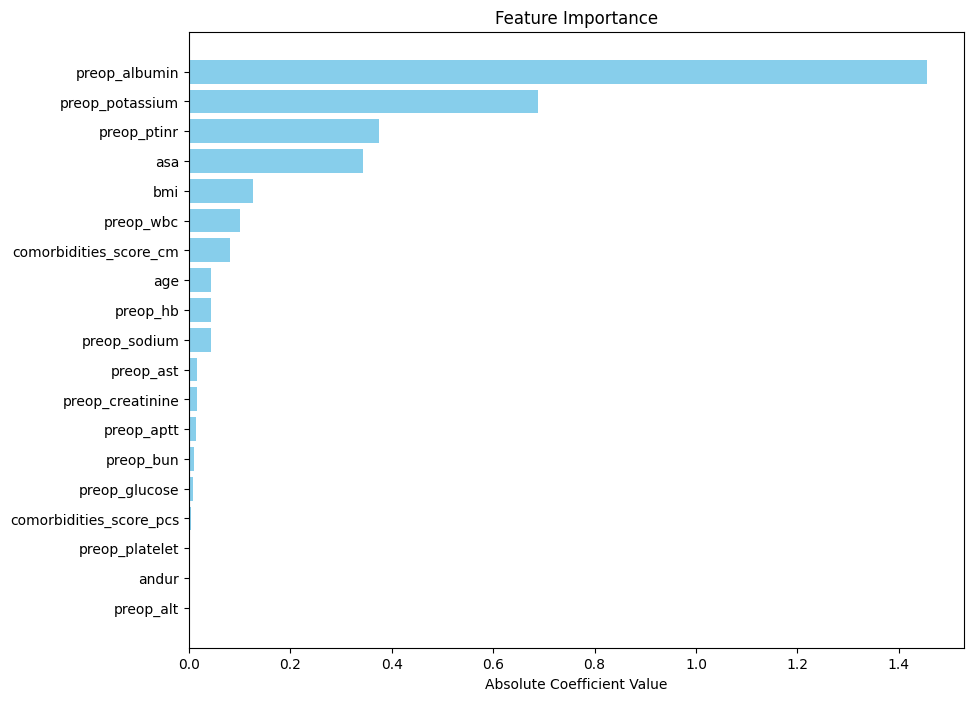

In [16]:
# Split a dataset into train and test sets
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
ntrain = int(len(df) * 0.7)

from sklearn.model_selection import train_test_split

# Stratified split
x_train, x_test, y_train, y_test = train_test_split(
    df[INPUT_VARS], df[OUTCOME_VAR], test_size=0.3, stratify=df[OUTCOME_VAR], random_state=1
)


# Print the number of train and test sets
print(f'{sum(y_train)}/{len(y_train)} ({np.mean(y_train)*100:.2f}%) train, {sum(y_test)}/{len(y_test)} ({np.mean(y_test)*100:.2f}%) test, {x_train.shape[1]} features', flush=True)

# ASA class
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
y_pred_asa = df.loc[ntrain:, 'asa']

# Compute area under the ROC AUC from prediction scores
auroc_asa = roc_auc_score(y_test, y_pred_asa)

# Compute the precision recall curve
prc_asa, rec_asa, thresholds = precision_recall_curve(y_test, y_pred_asa)

# Compute area under the precision-recall curve
auprc_asa = auc(rec_asa, prc_asa)
print('ASA auroc: {:.3f}, auprc: {:.3f}'.format(auroc_asa, auprc_asa), flush=True)

# Logistic regression using SimpleImputer()
from sklearn.impute import SimpleImputer
imp = SimpleImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# Logistic regression using LogisticRegression()
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=5000).fit(x_train_imputed, y_train)
y_pred_lr = model.predict_proba(x_test_imputed)[:, 1]

# compute AUROC and AUPRC
auroc_lr = roc_auc_score(y_test, y_pred_lr)
prc_lr, rec_lr, thresholds = precision_recall_curve(y_test, y_pred_lr)
auprc_lr = auc(rec_lr, prc_lr)
print('LR auroc: {:.3f}, auprc: {:.3f}'.format(auroc_lr, auprc_lr), flush=True)
print(" \n ")

# Compute feature importance
feature_names = x_train.columns
for feature_name, coef in zip(feature_names, model.coef_[0]):
  print(f"{feature_name}: {abs(coef)}")

fpr_asa, tpr_asa, _ = roc_curve(y_test, y_pred_asa)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

feature_names = x_train.columns
coefficients = model.coef_[0]

# Create a list of (feature_name, absolute_coefficient) tuples and sort them by the coefficient value
features_coefficients = sorted(zip(feature_names, abs(coefficients)), key=lambda x: x[1], reverse=True)

# Unzip the feature names and their corresponding coefficients into separate lists
sorted_features, sorted_coefficients = zip(*features_coefficients)

# Plot feature imoprtance
print("\n")
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # invert the y-axis to have the most important feature on top
plt.show()

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Define the number of splits for cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# Create a pipeline that first imputes missing values then fits a logistic model
pipeline = make_pipeline(SimpleImputer(), LogisticRegression(max_iter=5000))

# Define the metrics to evaluate the model
scoring = ['roc_auc', 'average_precision']

# Perform cross-validation
results = cross_validate(pipeline, df[INPUT_VARS], df[OUTCOME_VAR], cv=kf, scoring=scoring, return_train_score=False)

# Print the average results from cross-validation
print(f"Average ROC AUC: {results['test_roc_auc'].mean():.3f}")
print(f"Average Precision-Recall AUC: {results['test_average_precision'].mean():.3f}")

Average ROC AUC: 0.935
Average Precision-Recall AUC: 0.584


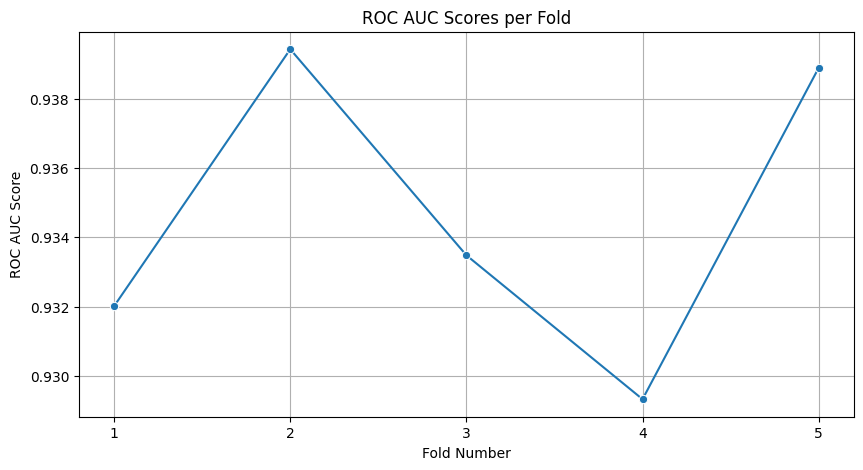

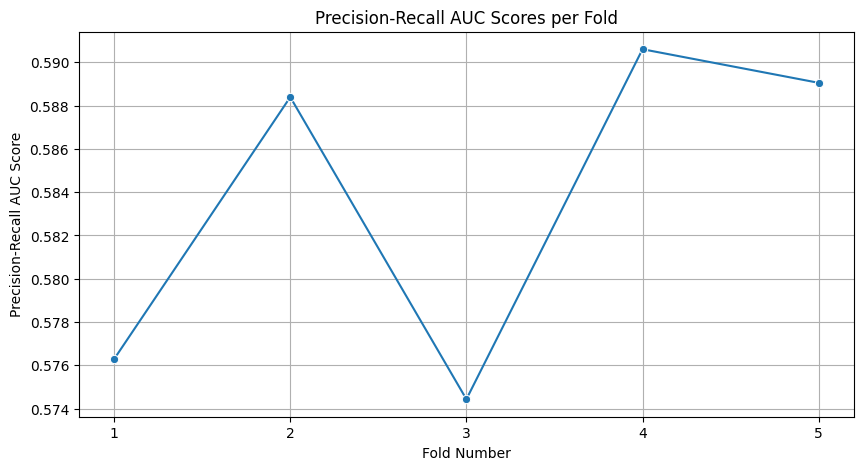

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ROC AUC scores across folds
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, n_splits + 1), y=results['test_roc_auc'], marker='o')
plt.title('ROC AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('ROC AUC Score')
plt.xticks(range(1, n_splits + 1))
plt.grid(True)
plt.show()

# Plotting Precision-Recall AUC scores across folds
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, n_splits + 1), y=results['test_average_precision'], marker='o')
plt.title('Precision-Recall AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Precision-Recall AUC Score')
plt.xticks(range(1, n_splits + 1))
plt.grid(True)
plt.show()